<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-DaraHeaphy/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [3]:
import torchvision.transforms as transforms

def getTransforms(augmentation=False):
    mean = (0.2860,)
    std = (0.3530,)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform


## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

def getTransforms(augmentation=False):
    mean = (0.2860,)
    std = (0.3530,)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform

def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    Load the FashionMNIST dataset and return train and test data loaders.
    """
    train_transform, test_transform = getTransforms(augmentation)

    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=test_transform
    )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 196kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)


        if self.useRegularization:
            self.dropout = nn.Dropout(p=dropout_prob)

        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        if self.useRegularization:
            x = self.dropout(x)

        out = self.fc2(x)
        return out


## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [6]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [8]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()

optimiser = optim.Adam(model.parameters(), lr=0.001)


In [9]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.303397  [   64/60000]
loss: 0.405162  [ 6464/60000]
loss: 0.478075  [12864/60000]
loss: 0.523980  [19264/60000]
loss: 0.375604  [25664/60000]
loss: 0.337749  [32064/60000]
loss: 0.296055  [38464/60000]
loss: 0.349198  [44864/60000]
loss: 0.275547  [51264/60000]
loss: 0.198463  [57664/60000]


Epochs:  10%|█         | 1/10 [00:51<07:44, 51.59s/it]

Train Error: 
 Accuracy: 89.3%, Avg loss: 0.294337 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.301726 

Epoch 2:

loss: 0.287394  [   64/60000]
loss: 0.247871  [ 6464/60000]
loss: 0.223595  [12864/60000]
loss: 0.273032  [19264/60000]
loss: 0.232728  [25664/60000]
loss: 0.334286  [32064/60000]
loss: 0.190136  [38464/60000]
loss: 0.219156  [44864/60000]
loss: 0.306897  [51264/60000]
loss: 0.238837  [57664/60000]


Epochs:  20%|██        | 2/10 [01:44<06:59, 52.40s/it]

Train Error: 
 Accuracy: 91.3%, Avg loss: 0.239494 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.251995 

Epoch 3:

loss: 0.238847  [   64/60000]
loss: 0.183437  [ 6464/60000]
loss: 0.322719  [12864/60000]
loss: 0.255367  [19264/60000]
loss: 0.236866  [25664/60000]
loss: 0.258545  [32064/60000]
loss: 0.353638  [38464/60000]
loss: 0.214931  [44864/60000]
loss: 0.171331  [51264/60000]
loss: 0.267115  [57664/60000]


Epochs:  30%|███       | 3/10 [02:36<06:04, 52.10s/it]

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.193766 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.225839 

Epoch 4:

loss: 0.121122  [   64/60000]
loss: 0.154688  [ 6464/60000]
loss: 0.308354  [12864/60000]
loss: 0.164743  [19264/60000]
loss: 0.224032  [25664/60000]
loss: 0.134509  [32064/60000]
loss: 0.179409  [38464/60000]
loss: 0.109447  [44864/60000]
loss: 0.264946  [51264/60000]
loss: 0.184384  [57664/60000]


Epochs:  40%|████      | 4/10 [03:23<05:02, 50.36s/it]

Train Error: 
 Accuracy: 92.9%, Avg loss: 0.189851 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.225874 

Epoch 5:

loss: 0.203194  [   64/60000]
loss: 0.189096  [ 6464/60000]
loss: 0.153909  [12864/60000]
loss: 0.145027  [19264/60000]
loss: 0.160018  [25664/60000]
loss: 0.184758  [32064/60000]
loss: 0.112774  [38464/60000]
loss: 0.151089  [44864/60000]
loss: 0.159518  [51264/60000]
loss: 0.167327  [57664/60000]


Epochs:  50%|█████     | 5/10 [04:12<04:07, 49.59s/it]

Train Error: 
 Accuracy: 93.6%, Avg loss: 0.171971 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.220784 

Epoch 6:

loss: 0.285946  [   64/60000]
loss: 0.074762  [ 6464/60000]
loss: 0.103101  [12864/60000]
loss: 0.171591  [19264/60000]
loss: 0.238204  [25664/60000]
loss: 0.255487  [32064/60000]
loss: 0.168030  [38464/60000]
loss: 0.147477  [44864/60000]
loss: 0.048664  [51264/60000]
loss: 0.092101  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:58<03:14, 48.61s/it]

Train Error: 
 Accuracy: 94.6%, Avg loss: 0.144270 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.215260 

Epoch 7:

loss: 0.177415  [   64/60000]
loss: 0.327550  [ 6464/60000]
loss: 0.083852  [12864/60000]
loss: 0.185392  [19264/60000]
loss: 0.231495  [25664/60000]
loss: 0.149766  [32064/60000]
loss: 0.313324  [38464/60000]
loss: 0.162207  [44864/60000]
loss: 0.136327  [51264/60000]
loss: 0.148153  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:45<02:24, 48.02s/it]

Train Error: 
 Accuracy: 94.9%, Avg loss: 0.137446 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.215540 

Epoch 8:

loss: 0.140325  [   64/60000]
loss: 0.110576  [ 6464/60000]
loss: 0.028096  [12864/60000]
loss: 0.072757  [19264/60000]
loss: 0.069033  [25664/60000]
loss: 0.220059  [32064/60000]
loss: 0.242961  [38464/60000]
loss: 0.071021  [44864/60000]
loss: 0.218240  [51264/60000]
loss: 0.111799  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:33<01:35, 47.79s/it]

Train Error: 
 Accuracy: 95.4%, Avg loss: 0.128048 

Test Error: 
 Accuracy: 93.1%, Avg loss: 0.207835 

Epoch 9:

loss: 0.116330  [   64/60000]
loss: 0.036868  [ 6464/60000]
loss: 0.041756  [12864/60000]
loss: 0.080426  [19264/60000]
loss: 0.076689  [25664/60000]
loss: 0.098915  [32064/60000]
loss: 0.057083  [38464/60000]
loss: 0.335954  [44864/60000]
loss: 0.069930  [51264/60000]
loss: 0.031369  [57664/60000]


Epochs:  90%|█████████ | 9/10 [07:21<00:47, 47.93s/it]

Train Error: 
 Accuracy: 95.6%, Avg loss: 0.118944 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.218035 

Epoch 10:

loss: 0.233353  [   64/60000]
loss: 0.215824  [ 6464/60000]
loss: 0.128015  [12864/60000]
loss: 0.056751  [19264/60000]
loss: 0.197837  [25664/60000]
loss: 0.247856  [32064/60000]
loss: 0.093203  [38464/60000]
loss: 0.210262  [44864/60000]
loss: 0.147998  [51264/60000]
loss: 0.117947  [57664/60000]


Epochs: 100%|██████████| 10/10 [08:10<00:00, 49.07s/it]

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.108675 

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.234850 

Done training!


Plotting metrics

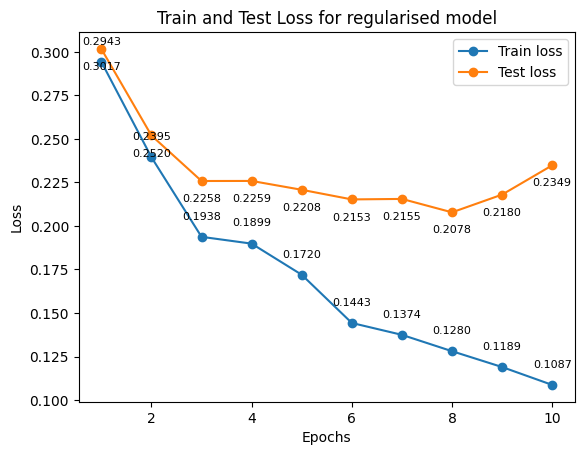

In [10]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

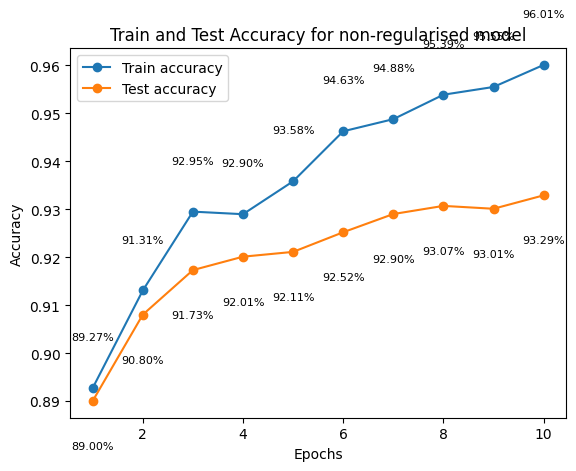

In [11]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [14]:
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NetFashion().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.309140  [   64/60000]
loss: 0.524884  [ 6464/60000]
loss: 0.327145  [12864/60000]
loss: 0.325210  [19264/60000]
loss: 0.290477  [25664/60000]
loss: 0.389434  [32064/60000]
loss: 0.484272  [38464/60000]
loss: 0.360311  [44864/60000]
loss: 0.364483  [51264/60000]
loss: 0.183375  [57664/60000]


Epochs:  20%|██        | 1/5 [00:49<03:19, 49.94s/it]

Train Error: 
 Accuracy: 89.2%, Avg loss: 0.296150 

Test Error: 
 Accuracy: 88.6%, Avg loss: 0.307410 

Epoch 2:

loss: 0.601524  [   64/60000]
loss: 0.362978  [ 6464/60000]
loss: 0.491023  [12864/60000]
loss: 0.436143  [19264/60000]
loss: 0.163187  [25664/60000]
loss: 0.201676  [32064/60000]
loss: 0.238734  [38464/60000]
loss: 0.196456  [44864/60000]
loss: 0.348266  [51264/60000]
loss: 0.243247  [57664/60000]


Epochs:  40%|████      | 2/5 [01:37<02:26, 48.68s/it]

Train Error: 
 Accuracy: 91.6%, Avg loss: 0.229418 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.256832 

Epoch 3:

loss: 0.066782  [   64/60000]
loss: 0.168575  [ 6464/60000]
loss: 0.190036  [12864/60000]
loss: 0.194692  [19264/60000]
loss: 0.096659  [25664/60000]
loss: 0.301315  [32064/60000]
loss: 0.256545  [38464/60000]
loss: 0.207466  [44864/60000]
loss: 0.248411  [51264/60000]
loss: 0.100001  [57664/60000]


Epochs:  60%|██████    | 3/5 [02:24<01:35, 47.98s/it]

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.203350 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.225197 

Epoch 4:

loss: 0.459365  [   64/60000]
loss: 0.235597  [ 6464/60000]
loss: 0.160879  [12864/60000]
loss: 0.313098  [19264/60000]
loss: 0.167350  [25664/60000]
loss: 0.164557  [32064/60000]
loss: 0.092785  [38464/60000]
loss: 0.266539  [44864/60000]
loss: 0.066830  [51264/60000]
loss: 0.142681  [57664/60000]


Epochs:  80%|████████  | 4/5 [03:12<00:47, 47.78s/it]

Train Error: 
 Accuracy: 93.4%, Avg loss: 0.177549 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.217720 

Epoch 5:

loss: 0.149762  [   64/60000]
loss: 0.168301  [ 6464/60000]
loss: 0.168647  [12864/60000]
loss: 0.247128  [19264/60000]
loss: 0.333338  [25664/60000]
loss: 0.287473  [32064/60000]
loss: 0.206303  [38464/60000]
loss: 0.178838  [44864/60000]
loss: 0.111882  [51264/60000]
loss: 0.121483  [57664/60000]


Epochs: 100%|██████████| 5/5 [04:00<00:00, 48.18s/it]

Train Error: 
 Accuracy: 94.1%, Avg loss: 0.158466 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.204945 

Done training!


Plotting metrics

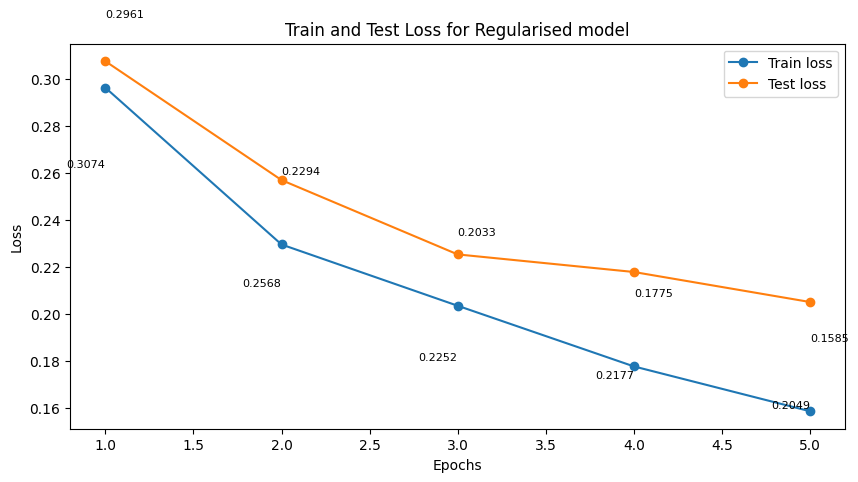

In [15]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

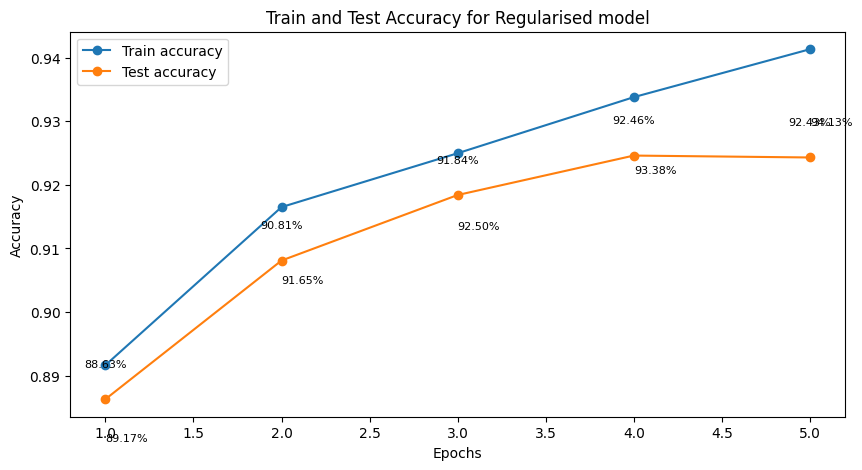

In [16]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [17]:
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.299506  [   64/60000]
loss: 0.483294  [ 6464/60000]
loss: 0.529048  [12864/60000]
loss: 0.283739  [19264/60000]
loss: 0.187900  [25664/60000]
loss: 0.225637  [32064/60000]
loss: 0.421701  [38464/60000]
loss: 0.446151  [44864/60000]
loss: 0.323271  [51264/60000]
loss: 0.278797  [57664/60000]


Epochs:  20%|██        | 1/5 [00:33<02:14, 33.57s/it]

Train Error: 
 Accuracy: 91.3%, Avg loss: 0.239612 

Test Error: 
 Accuracy: 89.8%, Avg loss: 0.278643 

Epoch 2:

loss: 0.248740  [   64/60000]
loss: 0.087129  [ 6464/60000]
loss: 0.307821  [12864/60000]
loss: 0.175555  [19264/60000]
loss: 0.158391  [25664/60000]
loss: 0.223422  [32064/60000]
loss: 0.223904  [38464/60000]
loss: 0.076999  [44864/60000]
loss: 0.312450  [51264/60000]
loss: 0.237142  [57664/60000]


Epochs:  40%|████      | 2/5 [01:06<01:39, 33.11s/it]

Train Error: 
 Accuracy: 93.3%, Avg loss: 0.179804 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.230319 

Epoch 3:

loss: 0.165921  [   64/60000]
loss: 0.242244  [ 6464/60000]
loss: 0.194113  [12864/60000]
loss: 0.268429  [19264/60000]
loss: 0.151376  [25664/60000]
loss: 0.217430  [32064/60000]
loss: 0.166219  [38464/60000]
loss: 0.376689  [44864/60000]
loss: 0.310107  [51264/60000]
loss: 0.209956  [57664/60000]


Epochs:  60%|██████    | 3/5 [01:40<01:07, 33.77s/it]

Train Error: 
 Accuracy: 94.9%, Avg loss: 0.136550 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.220692 

Epoch 4:

loss: 0.101105  [   64/60000]
loss: 0.113735  [ 6464/60000]
loss: 0.125087  [12864/60000]
loss: 0.161239  [19264/60000]
loss: 0.278578  [25664/60000]
loss: 0.077320  [32064/60000]
loss: 0.106515  [38464/60000]
loss: 0.132506  [44864/60000]
loss: 0.160556  [51264/60000]
loss: 0.072120  [57664/60000]


Epochs:  80%|████████  | 4/5 [02:13<00:33, 33.50s/it]

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.106257 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.219308 

Epoch 5:

loss: 0.039105  [   64/60000]
loss: 0.173307  [ 6464/60000]
loss: 0.099220  [12864/60000]
loss: 0.233491  [19264/60000]
loss: 0.049009  [25664/60000]
loss: 0.053638  [32064/60000]
loss: 0.111838  [38464/60000]
loss: 0.071766  [44864/60000]
loss: 0.137860  [51264/60000]
loss: 0.089164  [57664/60000]


Epochs: 100%|██████████| 5/5 [02:48<00:00, 33.74s/it]

Train Error: 
 Accuracy: 97.2%, Avg loss: 0.073087 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.226106 

Done training!


Plotting metrics

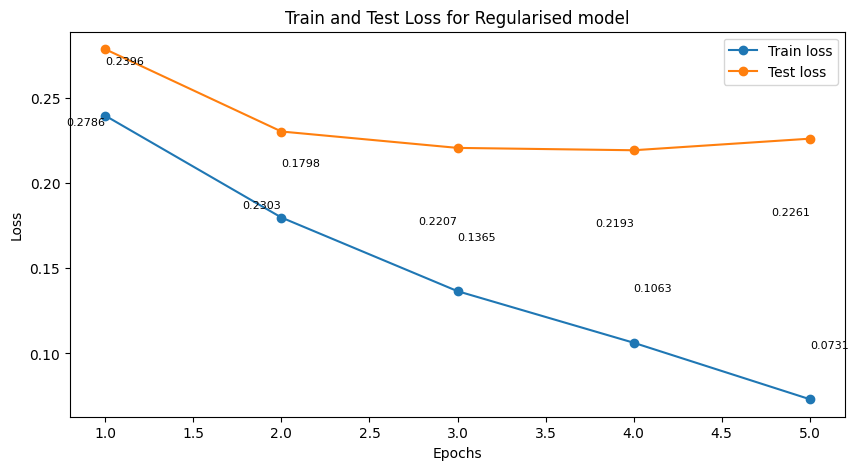

In [18]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

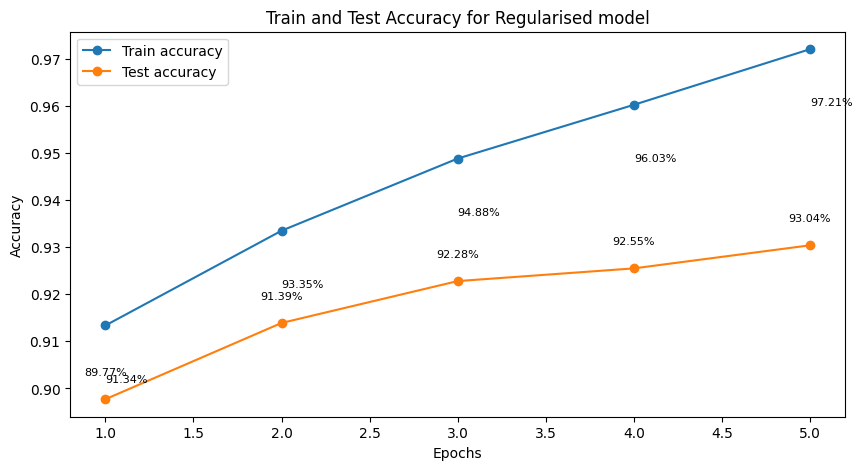

In [19]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [20]:
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NetFashion(dropout_prob=0.3, useRegularization=False).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.301239  [   64/60000]
loss: 0.511349  [ 6464/60000]
loss: 0.543597  [12864/60000]
loss: 0.365987  [19264/60000]
loss: 0.283682  [25664/60000]
loss: 0.377515  [32064/60000]
loss: 0.212505  [38464/60000]
loss: 0.326071  [44864/60000]
loss: 0.281491  [51264/60000]
loss: 0.282441  [57664/60000]


Epochs:  20%|██        | 1/5 [00:32<02:09, 32.50s/it]

Train Error: 
 Accuracy: 90.6%, Avg loss: 0.257431 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.297252 

Epoch 2:

loss: 0.299888  [   64/60000]
loss: 0.173039  [ 6464/60000]
loss: 0.271350  [12864/60000]
loss: 0.209440  [19264/60000]
loss: 0.207314  [25664/60000]
loss: 0.156414  [32064/60000]
loss: 0.177934  [38464/60000]
loss: 0.306174  [44864/60000]
loss: 0.232583  [51264/60000]
loss: 0.170625  [57664/60000]


Epochs:  40%|████      | 2/5 [01:05<01:37, 32.57s/it]

Train Error: 
 Accuracy: 92.9%, Avg loss: 0.192838 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.246777 

Epoch 3:

loss: 0.176103  [   64/60000]
loss: 0.094463  [ 6464/60000]
loss: 0.164338  [12864/60000]
loss: 0.132727  [19264/60000]
loss: 0.299035  [25664/60000]
loss: 0.318282  [32064/60000]
loss: 0.135743  [38464/60000]
loss: 0.142282  [44864/60000]
loss: 0.238693  [51264/60000]
loss: 0.254780  [57664/60000]


Epochs:  60%|██████    | 3/5 [01:38<01:05, 32.87s/it]

Train Error: 
 Accuracy: 93.9%, Avg loss: 0.165762 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.241728 

Epoch 4:

loss: 0.244204  [   64/60000]
loss: 0.179495  [ 6464/60000]
loss: 0.142707  [12864/60000]
loss: 0.174047  [19264/60000]
loss: 0.161157  [25664/60000]
loss: 0.224368  [32064/60000]
loss: 0.131432  [38464/60000]
loss: 0.190196  [44864/60000]
loss: 0.204942  [51264/60000]
loss: 0.113122  [57664/60000]


Epochs:  80%|████████  | 4/5 [02:10<00:32, 32.52s/it]

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.113020 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.198445 

Epoch 5:

loss: 0.143185  [   64/60000]
loss: 0.152378  [ 6464/60000]
loss: 0.067107  [12864/60000]
loss: 0.040868  [19264/60000]
loss: 0.125925  [25664/60000]
loss: 0.124426  [32064/60000]
loss: 0.168254  [38464/60000]
loss: 0.054333  [44864/60000]
loss: 0.085706  [51264/60000]
loss: 0.123651  [57664/60000]


Epochs: 100%|██████████| 5/5 [02:42<00:00, 32.55s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.122103 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.226255 

Done training!


Plotting metrics

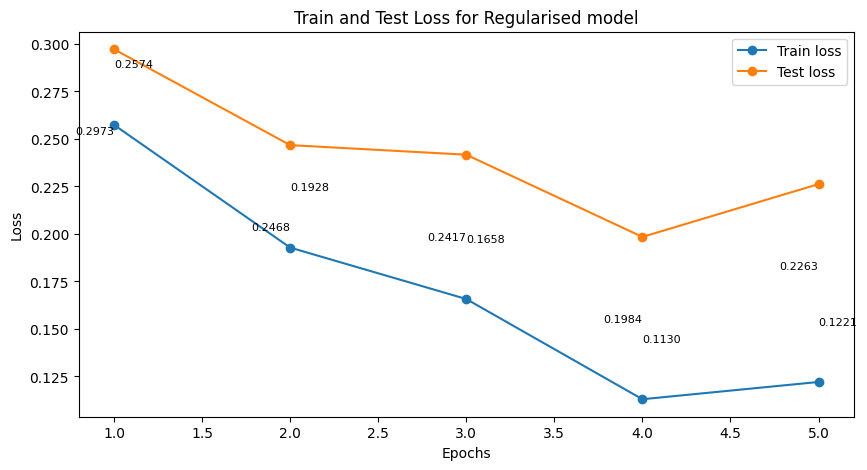

In [21]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

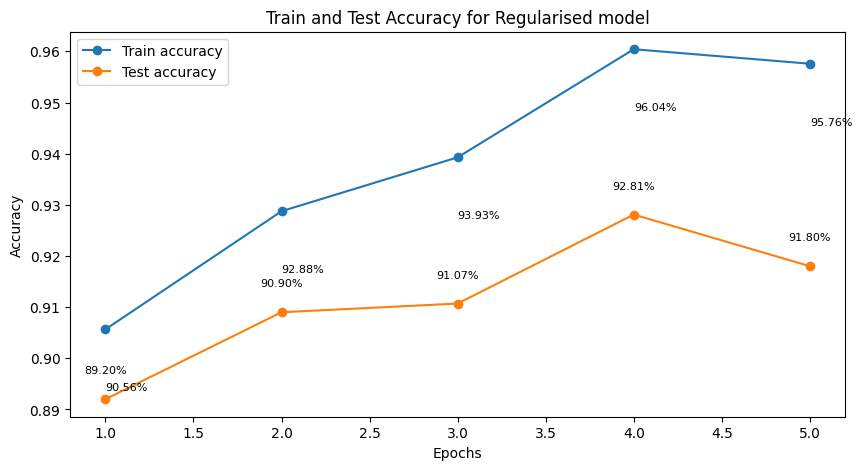

In [22]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [23]:
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.302026  [   64/60000]
loss: 0.572752  [ 6464/60000]
loss: 0.589787  [12864/60000]
loss: 0.407101  [19264/60000]
loss: 0.279942  [25664/60000]
loss: 0.274741  [32064/60000]
loss: 0.313886  [38464/60000]
loss: 0.294383  [44864/60000]
loss: 0.418050  [51264/60000]
loss: 0.372157  [57664/60000]


Epochs:  20%|██        | 1/5 [00:51<03:26, 51.65s/it]

Train Error: 
 Accuracy: 88.7%, Avg loss: 0.305706 

Test Error: 
 Accuracy: 88.2%, Avg loss: 0.313803 

Epoch 2:

loss: 0.422490  [   64/60000]
loss: 0.458128  [ 6464/60000]
loss: 0.222101  [12864/60000]
loss: 0.551851  [19264/60000]
loss: 0.259061  [25664/60000]
loss: 0.329906  [32064/60000]
loss: 0.132792  [38464/60000]
loss: 0.246184  [44864/60000]
loss: 0.121883  [51264/60000]
loss: 0.295840  [57664/60000]


Epochs:  40%|████      | 2/5 [01:39<02:27, 49.32s/it]

Train Error: 
 Accuracy: 90.2%, Avg loss: 0.257261 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.274612 

Epoch 3:

loss: 0.244233  [   64/60000]
loss: 0.157802  [ 6464/60000]
loss: 0.354530  [12864/60000]
loss: 0.210977  [19264/60000]
loss: 0.423865  [25664/60000]
loss: 0.358104  [32064/60000]
loss: 0.337911  [38464/60000]
loss: 0.139971  [44864/60000]
loss: 0.285143  [51264/60000]
loss: 0.099558  [57664/60000]


Epochs:  60%|██████    | 3/5 [02:27<01:37, 48.94s/it]

Train Error: 
 Accuracy: 91.7%, Avg loss: 0.225250 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.254130 

Epoch 4:

loss: 0.312675  [   64/60000]
loss: 0.171217  [ 6464/60000]
loss: 0.113916  [12864/60000]
loss: 0.198239  [19264/60000]
loss: 0.344669  [25664/60000]
loss: 0.142198  [32064/60000]
loss: 0.263489  [38464/60000]
loss: 0.279397  [44864/60000]
loss: 0.155128  [51264/60000]
loss: 0.173877  [57664/60000]


Epochs:  80%|████████  | 4/5 [03:15<00:48, 48.49s/it]

Train Error: 
 Accuracy: 92.2%, Avg loss: 0.211270 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.242100 

Epoch 5:

loss: 0.235350  [   64/60000]
loss: 0.163569  [ 6464/60000]
loss: 0.157958  [12864/60000]
loss: 0.184317  [19264/60000]
loss: 0.236560  [25664/60000]
loss: 0.320322  [32064/60000]
loss: 0.226862  [38464/60000]
loss: 0.364834  [44864/60000]
loss: 0.125040  [51264/60000]
loss: 0.311653  [57664/60000]


Epochs: 100%|██████████| 5/5 [04:03<00:00, 48.73s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.190659 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.217488 

Done training!


Plotting metrics

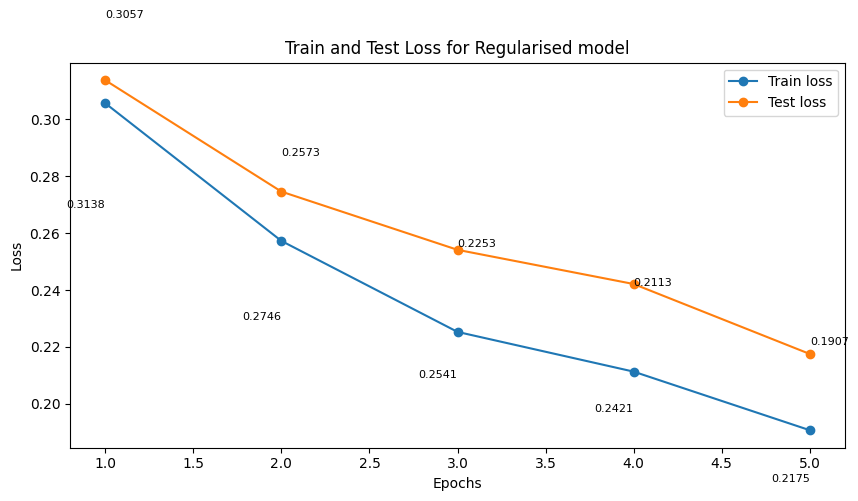

In [24]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

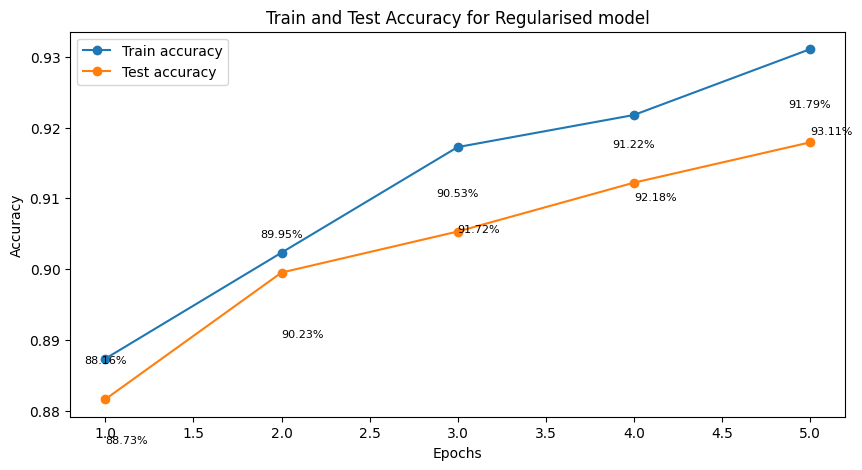

In [25]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='red'>When these techniques are used individually they provide some resistance to overfitting but when they're used together they provide a strong defense against overfitting. There should be a balance though as we dont want to underfit our model either. In terms of the techniques used here; data augmentation reduces the overfitting by exposing the model to diverse input data. weight decay keeps the model's parameters constrained which reduces overfitting and dropout regularization reduces the co-dependancy among neurons reducing generalization. </font>

